# Gaussian process as distribution over functions

In [1]:
import matplotlib.pyplot as plt
import torch

## Setting up training data

In [2]:
def forrester_1d(x):
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

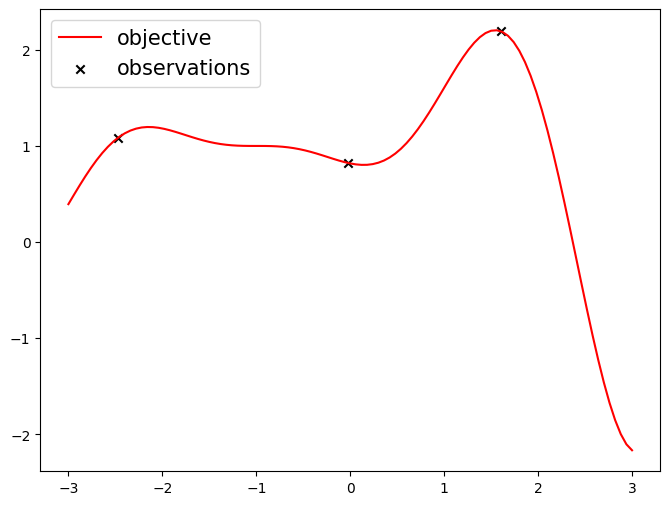

In [3]:
xs = torch.linspace(-3, 3, 101).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(0)
train_x = torch.rand(size=(3, 1)) * 6 - 3  # Generate random data between -3 and 3.
train_y = forrester_1d(train_x)

plt.figure(figsize=(8, 6))
plt.plot(xs, ys, label="objective", c="r")
plt.scatter(train_x, train_y, marker="x", c="k", label="observations")
plt.legend(fontsize=15);

## Implementing a GP class

In [4]:
import gpytorch

In [5]:
class BaseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # Outputs zero mean prediction in prior mode.
        self.mean_module = gpytorch.means.ZeroMean()

        # Covariance function. The idea is data points close to each other are correlated to each other.
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Making predictions with a GP

In [6]:
def plot_prediction(x, y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = BaseGPModel(x, y, likelihood)
    model.covar_module.lengthscale = 1
    model.likelihood.noise = 1e-4

    model.eval()
    likelihood.eval()

    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_lower, predictive_upper = predictive_distribution.confidence_region()

    torch.manual_seed(0)
    samples = predictive_distribution.sample(torch.Size([5]))
    plt.plot(xs, predictive_mean.detach(), label="mean")
    plt.fill_between(
        xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
    )
    for i in range(samples.shape[0]):
        plt.plot(xs, samples[i, :], alpha=0.5)

    plt.legend()

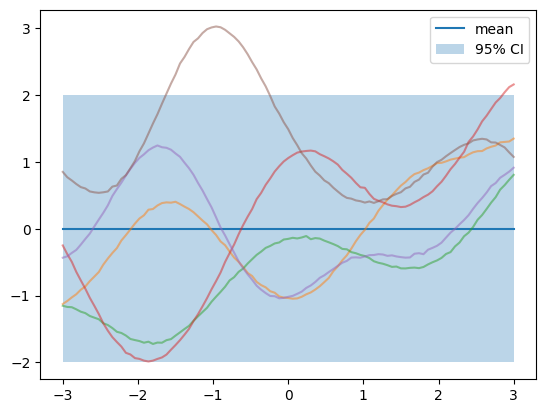

In [7]:
plot_prediction(None, None)

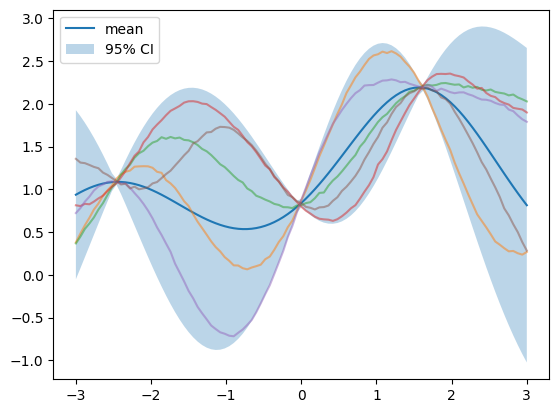

In [8]:
plot_prediction(train_x, train_y)

## Beyond one-dimensional objective functions

In [9]:
# training data
train_x = torch.tensor([[0.0, 0.0], [1.0, 2.0], [-1.0, 1]])
train_y = torch.tensor([0.0, -1.0, 0.5])

# test data
grid_x = torch.linspace(-3, 3, 101)
grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")
xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten()]).transpose(-1, -2)

In [10]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)
model.covar_module.lengthscale = 1
model.likelihood.noise = 1e-4

model.eval()
likelihood.eval()

with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_stddev = predictive_distribution.stddev

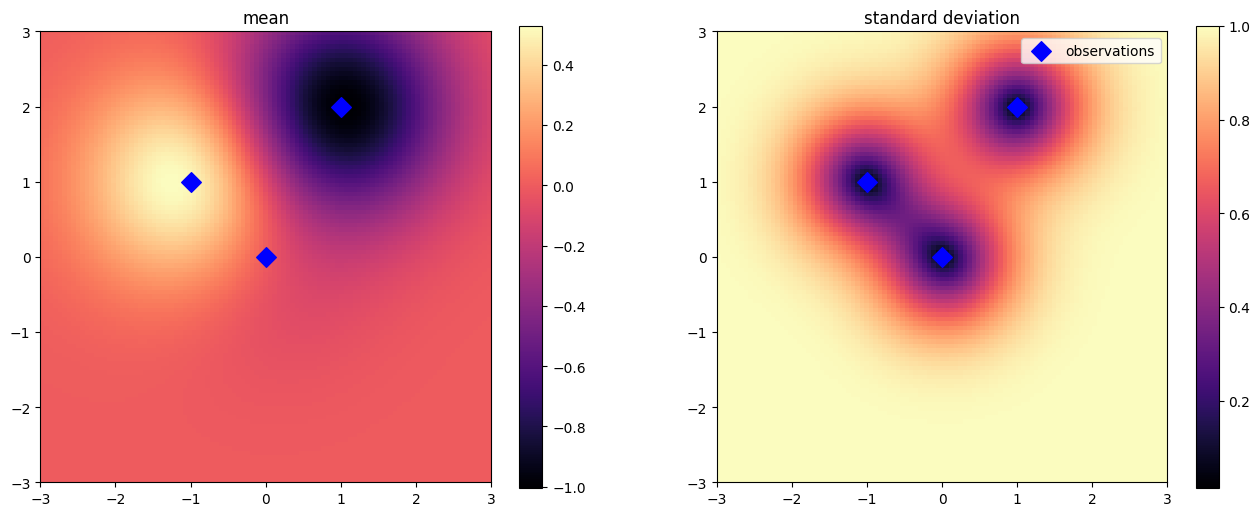

In [11]:
plt.rcParams["image.cmap"] = "magma"

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
c = ax[0].imshow(
    predictive_mean.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3],
)
plt.colorbar(c, ax=ax[0])
ax[0].scatter(train_x[:, 0], train_x[:, 1], c="blue", marker="D", s=100)
ax[0].set_title("mean")

c = ax[1].imshow(
    predictive_stddev.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3],
)
plt.colorbar(c, ax=ax[1])
ax[1].scatter(
    train_x[:, 0], train_x[:, 1], c="blue", marker="D", s=100, label="observations"
)
ax[1].set_title("standard deviation")
ax[1].legend()
plt.show()